# Background and Purpose

GANs are hard to evaluate.  The images they generate are often judged subjectively, based on how real they look.  The Frechet Inception distance (FID) was proposed as a way to more objectively evaluate GANs.  This notebook compares Pix2Pix and CycleGAN for the same image to image translation task, using the Edges2Shoes image set from the Pix2Pix dataset.  The FID is used to score the models.  Due to memory constraints, CycleGAN is run on a very small batch size, and the load_batch generator in the dataloader is restricted to 200 samples.  These restrictions should be removed for a fair comparison, but this would require more memory.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, 
    LeakyReLU, Activation, 
    Concatenate, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow_addons.layers.normalizations import InstanceNormalization
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.linalg import sqrtm

In [2]:
# define hardcoded values used throughout this notebook
IMAGE_SIZE = (256, 256)
IMAGE_SHAPE = (256, 256, 3)
DATASET_PATH = "/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes"
TRAIN_DIR = DATASET_PATH + "/train/"
VAL_DIR = DATASET_PATH + "/val/"
NBR_EPOCHS = 1
BATCH_SIZE = 5
MAX_TRAIN_SAMPLES = 200  # restricts training data to this many samples - use for testing and for limited resources

# Data Exploration

In [3]:
# get the file names in each directory, and count how many files there are

def only_images(ls):
    return [f for f in ls if f.endswith('.jpg')]

train_files = os.listdir(TRAIN_DIR)
val_files = os.listdir(VAL_DIR)

train_files = only_images(train_files)
val_files = only_images(val_files)

train_files = [TRAIN_DIR + "/" + file_path for file_path in train_files]
val_files = [VAL_DIR + "/" + file_path for file_path in val_files]

print(f"{len(train_files)} training files")
print(f"{len(val_files)} validation files")

49825 training files
200 validation files


Shape: (256, 512, 3)
Pixel Value Range: 0 255
Shape: (256, 512, 3)
Pixel Value Range: 0 255
Shape: (256, 512, 3)
Pixel Value Range: 0 255
Shape: (256, 512, 3)
Pixel Value Range: 0 255
Shape: (256, 512, 3)
Pixel Value Range: 0 255
Shape: (256, 512, 3)
Pixel Value Range: 0 255
Shape: (256, 512, 3)
Pixel Value Range: 0 255
Shape: (256, 512, 3)
Pixel Value Range: 0 255
Shape: (256, 512, 3)
Pixel Value Range: 0 255
Shape: (256, 512, 3)
Pixel Value Range: 0 255


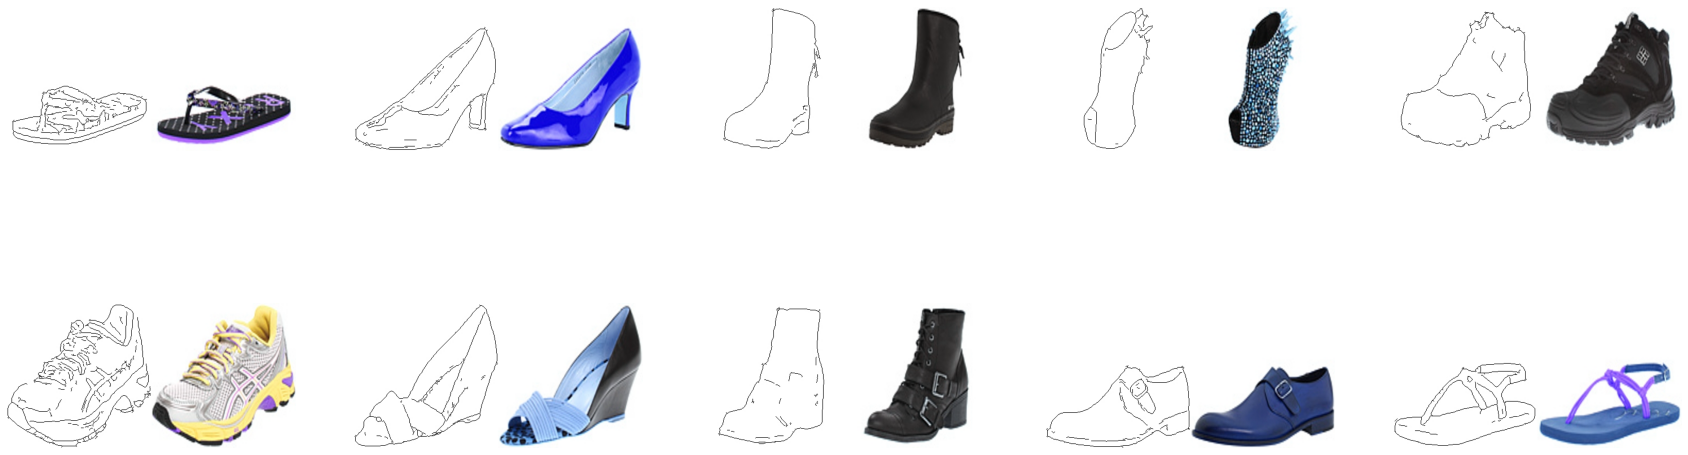

In [4]:
# show the pixel dimensions and value ranges of the first 10 training samples
sample_images = []
for i in train_files[:10]:
    img = cv2.imread(i)
    print("Shape:", img.shape)
    print("Pixel Value Range:", np.min(img), np.max(img))
    sample_images.append(img)
    
# visually inspect the images
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(30, 10))
for idx, img in enumerate(sample_images):
    axs[idx//5, idx%5].imshow(img, cmap='gray')
    axs[idx//5, idx%5].axis('off')
plt.show()

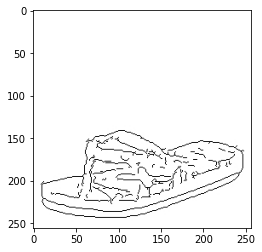

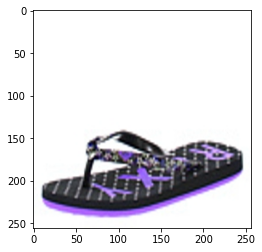

In [5]:
# ensure that edges and image are separable at pixel 256 in the x-dimension
sample0_edges, sample0_shoe = sample_images[0][:, :256], sample_images[0][:, 256:]
plt.imshow(sample0_edges)
plt.show()
plt.imshow(sample0_shoe)
plt.show()

# Utility Functions

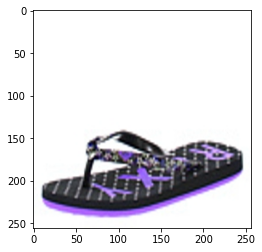

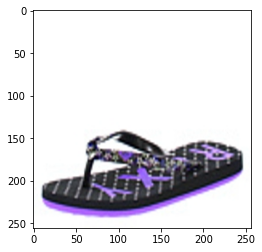

In [6]:
def resize_image(img, size=(28,28)):
    """
    Resizes an image to the given size.  
    Code inspired by: https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
    """
    # get the image's original height and width
    h, w = img.shape[:2]
    
    # get the image's original number of color channels
    c = img.shape[2] if len(img.shape) > 2 else 1

    # If the image is square already, simply resize it.
    #   Otherwise find which is longer (h or w), and create a square 
    #   image of zeros with the length equal to the larger dimension.
    #   Then paste the image into the square and resize the new image.
    if h == w: 
        return cv2.resize(img, size, cv2.INTER_AREA)
    else:
        # find the longer dimension
        longer_dim = h if h > w else w

        # Determine which interpolation method to use.  If the longer 
        #   dimension is larger than half the sum of the new image's height and width, 
        #   then use INTER_AREA.  Otherwise use INTER_CUBIC (bicubic interpolation).
        #   These methods take longer than others but ensure the least information loss.
        if longer_dim > (size[0] + size[1]) // 2:
            interpolation_method = cv2.INTER_AREA
        else:
            interpolation_method = cv2.INTER_CUBIC

        # get the coordinates of the original image
        x_pos = (longer_dim - w)//2
        y_pos = (longer_dim - h)//2

        # create an image of zeros, then copy the original
        #   image into position
        if len(img.shape) == 2:
            mask = np.zeros((longer_dim, longer_dim), dtype=img.dtype)
            mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
        else:
            mask = np.zeros((longer_dim, longer_dim, c), dtype=img.dtype)
            mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]

        return cv2.resize(mask, size, interpolation_method)


# test the resizing function on a single image
img = cv2.imread(train_files[0])[:, 256:]
new_img = resize_image(img=img, size=IMAGE_SIZE)
plt.imshow(img, cmap='gray')
plt.show()
plt.imshow(new_img, cmap='gray')
plt.show()

In [7]:
class DataLoader():
    def __init__(self, dataset_folder_path, img_size=(256, 256)):
        """
        Constructs a DataLoader object
        
        :params:
            dataset_folder_path (str): The path to the folder of 
                images to be loaded.  This is the name of the Pix2Pix dataset, 
                like edges2shoes.
            image_shape (tuple): Tuple of the image dimensions like (x, y).
        """
        self.dataset_folder_path = dataset_folder_path
        self.img_size = img_size
        self.nbr_batches = None

    def load_data(self, batch_size=1, use_for_training=True):
        """
        Loads data
        """
        if use_for_training:
            image_folder_path = self.dataset_folder_path + "/train"
        else:
            image_folder_path = self.dataset_folder_path + "/val"
        
        # get a list of the files in the given path
        image_files = os.listdir(image_folder_path)
        image_files = [image_folder_path + "/" + i for i in image_files]
        if MAX_TRAIN_SAMPLES is not None:
            image_files = image_files[:MAX_TRAIN_SAMPLES]

        # randomly sample batch_size number of images from the given path
        batch_images = np.random.choice(image_files, size=batch_size)

        source_images = []
        target_images = []
        
        for img_path in batch_images:
            img = cv2.imread(img_path)
            
            # split the source from the target image at the pixel in the 
            #   width dimension that is 1/2 the total width (that's just 
            #   the way the images were created)
            h, w, channels = img.shape
            half_w = int(w/2)
            source_img = img[:, :half_w, :]
            target_img = img[:, half_w:, :]
            
            # resize images
            source_img = resize_image(source_img, self.img_size)
            target_img = resize_image(target_img, self.img_size)

            # if training, randomly flip 1/2 the images
            if use_for_training and np.random.random() < 0.5:
                source_img = np.fliplr(source_img)
                target_img = np.fliplr(target_img)

            source_images.append(source_img)
            target_images.append(target_img)

        # stack the batch images into a numpy array and scale pixels 
        #   to range from -1 to 1
        source_images = np.array(source_images)/127.5 - 1.
        target_images = np.array(target_images)/127.5 - 1.

        return source_images, target_images

    def load_batch(self, batch_size=1, use_for_training=True):
        """
        A batch load generator
        """
        if use_for_training:
            image_folder_path = self.dataset_folder_path + "/train"
        else:
            image_folder_path = self.dataset_folder_path + "/val"

        # get a list of the files in the given path
        image_files = os.listdir(image_folder_path)
        image_files = [image_folder_path + "/" + i for i in image_files]
        if MAX_TRAIN_SAMPLES is not None:
            image_files = image_files[:MAX_TRAIN_SAMPLES]
        
        # determine how many batches, based on the number of files 
        #   and the batch size
        self.nbr_batches = int(len(image_files) / batch_size)

        for i in range(self.nbr_batches-1):
            batch = image_files[i*batch_size:(i+1)*batch_size]

            source_images = []
            target_images = []
            
            for img in batch:
                img = cv2.imread(img)
                
                # split the source from the target image at the pixel in the 
                #   width dimension that is 1/2 the total width (that's just 
                #   the way the images were created)
                h, w, channels = img.shape
                half_w = int(w/2)
                source_img = img[:, :half_w, :]
                target_img = img[:, half_w:, :]

                # resize images
                source_img = resize_image(source_img, self.img_size)
                target_img = resize_image(target_img, self.img_size)

                # if training, randomly flip 1/2 the images
                if use_for_training and np.random.random() < 0.5:
                    source_img = np.fliplr(source_img)
                    target_img = np.fliplr(target_img)

                source_images.append(source_img)
                target_images.append(target_img)

            # stack the batch images into a numpy array and scale pixels 
            #   to range from -1 to 1
            source_images = np.array(source_images)/127.5 - 1.
            target_images = np.array(target_images)/127.5 - 1.
            
            yield source_images, target_images


# test the data loader on a single image
loader = DataLoader(
    dataset_folder_path=DATASET_PATH,
    img_size=IMAGE_SIZE
)
train_source, train_target = loader.load_data(batch_size=1, use_for_training=True)
train_source.shape

(1, 256, 256, 3)

In [8]:
# test the data loader on a batch
loader = DataLoader(
    dataset_folder_path=DATASET_PATH,
    img_size=IMAGE_SIZE
)
for batch_nbr, batch in enumerate(loader.load_batch(batch_size=10, use_for_training=False)):
    print('batch nbr', batch_nbr, batch[0].shape, batch[1].shape)

batch nbr 0 (10, 256, 256, 3) (10, 256, 256, 3)
batch nbr 1 (10, 256, 256, 3) (10, 256, 256, 3)
batch nbr 2 (10, 256, 256, 3) (10, 256, 256, 3)
batch nbr 3 (10, 256, 256, 3) (10, 256, 256, 3)
batch nbr 4 (10, 256, 256, 3) (10, 256, 256, 3)
batch nbr 5 (10, 256, 256, 3) (10, 256, 256, 3)
batch nbr 6 (10, 256, 256, 3) (10, 256, 256, 3)
batch nbr 7 (10, 256, 256, 3) (10, 256, 256, 3)
batch nbr 8 (10, 256, 256, 3) (10, 256, 256, 3)
batch nbr 9 (10, 256, 256, 3) (10, 256, 256, 3)
batch nbr 10 (10, 256, 256, 3) (10, 256, 256, 3)
batch nbr 11 (10, 256, 256, 3) (10, 256, 256, 3)
batch nbr 12 (10, 256, 256, 3) (10, 256, 256, 3)
batch nbr 13 (10, 256, 256, 3) (10, 256, 256, 3)
batch nbr 14 (10, 256, 256, 3) (10, 256, 256, 3)
batch nbr 15 (10, 256, 256, 3) (10, 256, 256, 3)
batch nbr 16 (10, 256, 256, 3) (10, 256, 256, 3)
batch nbr 17 (10, 256, 256, 3) (10, 256, 256, 3)
batch nbr 18 (10, 256, 256, 3) (10, 256, 256, 3)


In [9]:
def load_real_samples(batch_size, nbr_patches):
    """
    Uses a DataLoader object to load a batch of real image
    samples.  Returns the source and target images, along with the
    label (label = all ones because they are all real images).
    """
    loader = DataLoader(
        dataset_folder_path=DATASET_PATH,
        img_size=IMAGE_SIZE
    )
    real_source_images, real_target_images = loader.load_data(
        batch_size=batch_size,
        use_for_training=True
    )
    y = np.ones((len(real_source_images), nbr_patches, nbr_patches, 1))
    return [real_source_images, real_target_images], y


# sense check: should see images here
# [x_real_source, x_real_target], y_real = load_real_samples(batch_size=10, nbr_patches=16)
# plt.imshow(x_real_source[0]) # source image (edges)
# plt.show()
# plt.imshow(x_real_target[0]) # target image (shoe)
# plt.show()


def generate_fake_samples(generator, real_source_image_samples, nbr_patches):
    """
    Uses a generator model to generate a batch of fake target image
    samples.  Returns the generated images and their label (label = all
    zeros because they are all fake images).
    """
    fake_target_images = generator.predict(real_source_image_samples)
    y = np.zeros((len(fake_target_images), nbr_patches, nbr_patches, 1))
    return fake_target_images, y

# Build Pix2Pix Model

In [10]:
class Pix2Pix:
    def __init__(self, input_image_shape):
        """
        Pix2Pix constructor.

        :params:
            input_image_shape: Tuple of (rows, cols, channels),
                where rows and cols are measured in pixels.  Pix2Pix
                was trained on 256x256x3 shape images, originally.
        """
        self.image_shape = input_image_shape
        self.data_loader = DataLoader(
            dataset_folder_path=DATASET_PATH,
            img_size=input_image_shape[:2]
        )
        # attributes that are defined by methods
        self.discriminator = None
        self.generator = None
        self.discriminator_nbr_patches = None
        self.gan = None

    def _build_discriminator(self):
        """
        The discriminator is a deep CNN that takes the source image
        and target image, and predicts whether the target image is a
        real or fake translation of the source image.
        """
        initial_weights = RandomNormal(stddev=0.02)

        source_image = Input(shape=self.image_shape)
        target_image = Input(shape=self.image_shape)

        combined_images = Concatenate()([source_image, target_image])

        # C64
        x = Conv2D(
            filters=64, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(combined_images)
        x = LeakyReLU(alpha=0.2)(x)
        # C128
        x = Conv2D(
            filters=128, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        # C256
        x = Conv2D(
            filters=256, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        # C512
        x = Conv2D(
            filters=512, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        # second last output layer
        x = Conv2D(
            filters=512, kernel_size=(4, 4),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        # patch output
        x = Conv2D(
            filters=1, kernel_size=(4, 4),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        patch_out = Activation('sigmoid')(x)
        # define model
        model = Model([source_image, target_image], patch_out)
        # compile model
        opt = Adam(lr=0.0002, beta_1=0.5)
        model.compile(
            loss='binary_crossentropy',
            optimizer=opt,
            loss_weights=[0.5]
        )

        return model

    @staticmethod
    def encoder_block(layer_in, nbr_filters, batch_norm=True):
        """
        Encoder block in the U-net architecture that downsamples
        the input (layer_in) using strided convolution, optionally
        applying batch normalization, and using leaky relu activation.
        """
        initial_weights = RandomNormal(stddev=0.02)

        # downsampling layer
        x = Conv2D(
            filters=nbr_filters, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(layer_in)

        if batch_norm:
            x = BatchNormalization()(x, training=True)

        x = LeakyReLU(alpha=0.2)(x)

        return x

    @staticmethod
    def decoder_block(layer_in, skip_in, nbr_filters, dropout=True):
        """
        Decoder block in the U-net architecture that upsamples the
        the input (layer_in) using strided convolution, batch
        normalization, optional dropout, and relu activation.  The
        skip connection from the encoder must also be added, right
        before the activation.
        """
        initial_weights = RandomNormal(stddev=0.02)

        # add upsampling layer
        x = Conv2DTranspose(
            filters=nbr_filters, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(layer_in)

        # add batch normalization
        x = BatchNormalization()(x, training=True)

        # conditionally add dropout
        if dropout:
            x = Dropout(0.5)(x, training=True)

        # merge with skip connection
        x = Concatenate()([x, skip_in])

        # relu activation
        x = Activation('relu')(x)

        return x

    def _build_generator(self):
        """
        The generator is an encoder-decoder model with a U-net
        architecture.  It takes an image from the source domain
        as input, and generates an image from the target domain
        as output.  The tanh activation produces an output with
        values ranged from -1 to 1.
        """
        initial_weights = RandomNormal(stddev=0.02)

        input_image = Input(shape=self.image_shape)

        # encoder model
        e1 = Pix2Pix.encoder_block(
            layer_in=input_image,
            nbr_filters=64,
            batch_norm=False
        )
        e2 = Pix2Pix.encoder_block(e1, 128)
        e3 = Pix2Pix.encoder_block(e2, 256)
        e4 = Pix2Pix.encoder_block(e3, 512)
        e5 = Pix2Pix.encoder_block(e4, 512)
        e6 = Pix2Pix.encoder_block(e5, 512)
        e7 = Pix2Pix.encoder_block(e6, 512)

        # bottleneck layer
        b = Conv2D(
            filters=512, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(e7)
        b = Activation('relu')(b)

        # decoder model
        d1 = Pix2Pix.decoder_block(
            layer_in=b,
            skip_in=e7,
            nbr_filters=512,
            dropout=True
        )
        d2 = Pix2Pix.decoder_block(d1, e6, 512)
        d3 = Pix2Pix.decoder_block(d2, e5, 512)
        d4 = Pix2Pix.decoder_block(d3, e4, 512, dropout=False)
        d5 = Pix2Pix.decoder_block(d4, e3, 256, dropout=False)
        d6 = Pix2Pix.decoder_block(d5, e2, 128, dropout=False)
        d7 = Pix2Pix.decoder_block(d6, e1, 64, dropout=False)

        # output
        x = Conv2DTranspose(
            filters=3, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(d7)
        output_image = Activation('tanh')(x)

        # define model
        model = Model(input_image, output_image)

        return model

    def _build_gan(self):
        """
        Builds the Pix2Pix GAN such that the discriminator trains on
        the real and generated images, while the generator trains
        by means of the discriminator.  The generator updates to minimize
        the L1 loss (error between real and fake images), and the
        adversarial loss (error of the discriminator).  The updates
        weight these losses at a 100:1 ratio in favor of the L1 loss,
        in accordance with the Pix2Pix paper.

        Balancing both losses requires specifying a separate model that
        stacks the generator on the discriminator and feeds a source
        image to both.  Since the output of the generator is also
        the discriminator's target image (which is concatenated with the
        source image as input), the discriminator can predict
        whether the generated image is a real or fake translation of the
        source image.
        """
        source_image = Input(shape=self.image_shape)

        # build discriminator and generator
        self.discriminator = self._build_discriminator()
        self.generator = self._build_generator()

        # store the discriminator output number of patches
        self.discriminator_nbr_patches = self.discriminator.output_shape[1]

        # freeze discriminator weights for this combined model
        self.discriminator.trainable = False

        # map inputs and outputs
        generator_output = self.generator(source_image)
        discriminator_output = self.discriminator([source_image, generator_output])

        # model takes source image as input,
        # produces generated image and real/fake prediction as output
        model = Model(source_image, [discriminator_output, generator_output])

        model.compile(
            loss=['binary_crossentropy', 'mae'],
            optimizer=Adam(lr=0.0002, beta_1=0.5),
            loss_weights=[1, 100]
        )

        return model
    
    def save_samples(self, epoch, batch_i):
        """
        Saves samples of source, target, and generated images to the 
        generated_images directory.
        """
        os.makedirs('generated_images/', exist_ok=True)
        r, c = 3, 3
        
        # load source and target images, and generate a fake image
        source_imgs, target_imgs = self.data_loader.load_data(batch_size=3, use_for_training=False)
        fake_imgs = self.generator.predict(target_imgs)
        
        # combine them and rescale them to range from 0 to 1
        gen_imgs = np.concatenate([target_imgs, fake_imgs, source_imgs])
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        titles = ['Condition', 'Generated', 'Original']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("generated_images/%d_%d.png" % (epoch, batch_i))
        plt.close()

    def train(self, nbr_epochs, batch_size, sample_interval=100):
        """
        Trains the GAN.  In each iteration, the discriminator is first
        updated with real samples, and then with fake/generated samples.
        Then the generator is updated.
        """
        # build the GAN
        self.gan = self._build_gan()
        
        for epoch in range(nbr_epochs):

            print("Epoch", epoch, "of", nbr_epochs)
            d_loss_real_hist, d_loss_fake_hist, g_loss_hist = [], [], []

            for batch_i, (x_real_source, x_real_target) in enumerate(
                self.data_loader.load_batch(batch_size)
            ):
                # create corresponding real labels
                y_real = np.ones((
                    len(x_real_source), 
                    self.discriminator_nbr_patches,
                    self.discriminator_nbr_patches,
                    1
                ))
                
                # generate a batch of fake samples
                x_fake_target, y_fake = generate_fake_samples(
                    generator=self.generator, 
                    real_source_image_samples=x_real_source, 
                    nbr_patches=self.discriminator_nbr_patches
                )
                
                # update discriminator for real samples
                d_loss_real = self.discriminator.train_on_batch(
                    [x_real_source, x_real_target], 
                    y_real
                )
                d_loss_real_hist.append(d_loss_real)
                
                # update discriminator for generated samples
                d_loss_fake = self.discriminator.train_on_batch(
                    [x_real_source, x_fake_target], 
                    y_fake
                )
                d_loss_fake_hist.append(d_loss_fake)
                
                # update the generator
                g_loss, _, _ = self.gan.train_on_batch(
                    x_real_source, 
                    [y_real, x_real_target]
                )
                g_loss_hist.append(g_loss)
                
                # store sample images
                if batch_i % sample_interval == 0:
                    self.save_samples(epoch=epoch, batch_i=batch_i)

            # show performance on epoch (indent this block for batch level performance)
            print(
                f"Epoch {epoch+1} batch {batch_i+1} performance:\n", 
                f"Discriminator real loss: {d_loss_real} \n",
                f"Discriminator fake loss: {d_loss_fake} \n",
                f"Generator loss: {g_loss} \n"
            )

        # return the loss hist for the final epoch
        return d_loss_real_hist, d_loss_fake_hist, g_loss_hist
    
    def save_generator(self):
        """
        Saves a trained Pix2Pix generator model to a h5 file.
        """
        filename = "pix2pix_generator_model.h5"
        self.generator.save(filename)


p2p = Pix2Pix(input_image_shape=IMAGE_SHAPE)
d_loss_real, d_loss_fake, g_loss = p2p.train(
    nbr_epochs=NBR_EPOCHS, 
    batch_size=BATCH_SIZE,
    sample_interval=10
)
p2p.save_generator()

Epoch 0 of 1
Epoch 1 batch 39 performance:
 Discriminator real loss: 0.03500957414507866 
 Discriminator fake loss: 0.049332454800605774 
 Generator loss: 35.203392028808594 



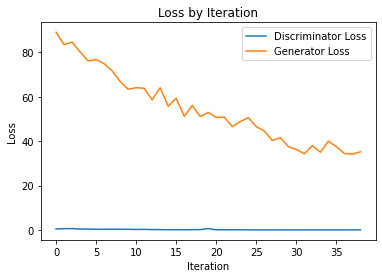

In [11]:
# plot the loss by training iteration
plt.plot(d_loss_real, label="Discriminator Loss")
plt.plot(g_loss, label="Generator Loss")
plt.title("Loss by Iteration")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.legend()
plt.show()

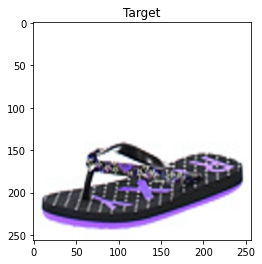

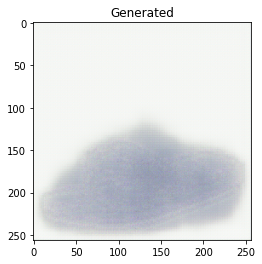

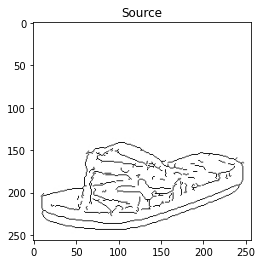

In [12]:
# load the model and make prediction on a given image
p2p_model = load_model('pix2pix_generator_model.h5')
source_img = cv2.imread(train_files[0])[:, :256]
target_img = cv2.imread(train_files[0])[:, 256:]

# resize
source_img = resize_image(img=source_img, size=IMAGE_SIZE)
target_img = resize_image(img=target_img, size=IMAGE_SIZE)

# scale pixel values
source_img = np.array(source_img)/127.5 - 1.
target_img = np.array(target_img)/127.5 - 1.

# reshape
source_img = np.expand_dims(source_img, 0)
target_img = np.expand_dims(target_img, 0)

# make prediction, re-scale and reshape
gen_img = p2p_model.predict(source_img)[0]
gen_img = (gen_img + 1) / 2.0
gen_img = np.expand_dims(gen_img, 0)

# combine and re-scale to (0, 1)
all_imgs = np.concatenate([target_img, gen_img, source_img])
all_imgs = 0.5 * all_imgs + 0.5

titles = ['Target', 'Generated', 'Source']
for idx, i in enumerate(all_imgs):
    plt.imshow(i)
    plt.title(titles[idx])
    plt.show()

# Build CycleGAN

In [13]:
class CycleGAN:
    def __init__(self, input_image_shape):
        """
        CycleGAN constructor.

        :params:
            input_image_shape: Tuple of (rows, cols, channels),
                where rows and cols are measured in pixels.  A
                256x256x3 shape is a good starting point, but the patch
                architecture makes it agnostic to image size.
        """
        self.image_shape = input_image_shape
        self.data_loader = DataLoader(
            dataset_folder_path=DATASET_PATH,
            img_size=input_image_shape[:2]
        )
        # Calculate output shape of D (PatchGAN)
        patch = int(input_image_shape[0] / 2 ** 4)
        self.discriminator_patch_size = (patch, patch, 1)
        # attributes that are defined by methods
        self.generator_AtoB = None
        self.generator_BtoA = None
        self.discriminator_A = None
        self.discriminator_B = None
        self.combined_AtoB = None
        self.combined_BtoA = None

    def _build_discriminator(self):
        """
        The discriminator is a deep CNN that takes the source image as
        input and predicts whether the target image is a real or fake
        translation of the source image.  The output is a patch that
        maps to 70x70 pixels in the source image.  This allows it to
        work with images of different sizes.

        The MSE loss uses a weighting scheme of 0.5 to slow the updates
        to the discriminator during GAN training.
        """
        initial_weights = RandomNormal(stddev=0.02)

        source_image = Input(shape=self.image_shape)

        # C64
        x = Conv2D(
            filters=64, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(source_image)
        x = LeakyReLU(alpha=0.2)(x)
        # C128
        x = Conv2D(
            filters=128, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        x = InstanceNormalization(axis=-1)(x)
        x = LeakyReLU(alpha=0.2)(x)
        # C256
        x = Conv2D(
            filters=256, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        x = InstanceNormalization(axis=-1)(x)
        x = LeakyReLU(alpha=0.2)(x)
        # C512
        x = Conv2D(
            512, (4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        x = InstanceNormalization(axis=-1)(x)
        x = LeakyReLU(alpha=0.2)(x)
        # second last output layer
        x = Conv2D(
            512, (4, 4),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        x = InstanceNormalization(axis=-1)(x)
        x = LeakyReLU(alpha=0.2)(x)
        # patch output
        patch_out = Conv2D(
            1, (4, 4),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        # define model
        model = Model(source_image, patch_out)
        # compile model
        model.compile(
            loss='mse',
            optimizer=Adam(lr=0.0002, beta_1=0.5),
            loss_weights=[0.5]
        )

        return model

    @staticmethod
    def resnet_block(n_filters, input_layer):
        """
        A ResNet block with two 3x3 convolutional layers (1x1 stride).
        This block will be used with skip connections in the generator.
        """
        initial_weights = RandomNormal(stddev=0.02)

        # first layer convolutional layer
        x = Conv2D(
            filters=n_filters, kernel_size=(3, 3),
            padding='same',
            kernel_initializer=initial_weights
        )(input_layer)
        x = InstanceNormalization(axis=-1)(x)
        x = Activation('relu')(x)
        # second convolutional layer
        x = Conv2D(
            filters=n_filters, kernel_size=(3, 3),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        x = InstanceNormalization(axis=-1)(x)
        # concatenate merge channel-wise with input layer
        x = Concatenate()([x, input_layer])

        return x

    def _build_generator(self, nbr_resnet_blocks=9):
        """
        The generator is a ResNet model with a U-net architecture.
        It takes an image from the source domain as input, and generates
        an image from the target domain as output.  This is accomplished
        by downsampling the source image to the bottleneck in the U-net
        architecture, then interpreting the downsampled encoding with a
        ResNet block that use skip connections, and then upsampling the
        representation back to the original size.  The tanh activation
        in the final layer produces an output with values ranged from -1 to 1.
        """
        initial_weights = RandomNormal(stddev=0.02)

        source_image = Input(shape=self.image_shape)

        # c7s1-64
        x = Conv2D(
            filters=64, kernel_size=(7, 7),
            padding='same',
            kernel_initializer=initial_weights
        )(source_image)
        x = InstanceNormalization(axis=-1)(x)
        x = Activation('relu')(x)
        # d128
        x = Conv2D(
            filters=128, kernel_size=(3, 3),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        x = InstanceNormalization(axis=-1)(x)
        x = Activation('relu')(x)
        # d256
        x = Conv2D(
            filters=256, kernel_size=(3, 3),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        x = InstanceNormalization(axis=-1)(x)
        x = Activation('relu')(x)
        # R256
        for _ in range(nbr_resnet_blocks):
            x = CycleGAN.resnet_block(256, x)
        # u128
        x = Conv2DTranspose(
            filters=128, kernel_size=(3, 3),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        x = InstanceNormalization(axis=-1)(x)
        x = Activation('relu')(x)
        # u64
        x = Conv2DTranspose(
            filters=64, kernel_size=(3, 3),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        x = InstanceNormalization(axis=-1)(x)
        x = Activation('relu')(x)
        # c7s1-3
        x = Conv2D(
            filters=3, kernel_size=(7, 7),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        x = InstanceNormalization(axis=-1)(x)
        output_image = Activation('tanh')(x)
        # define model
        model = Model(source_image, output_image)

        return model

    def _build_combined(self, generator_1, generator_2, discriminator):
        """
        Builds the combined model for the provided generators and discriminator.
        This function sets up the linking between various generators.  See the
        _build_gan method docstring for a complete mapping.

        Only the weights of generator A are updated in the combined model,
        using the weighted sum of all 4 loss functions.  The cycle loss is
        given 10 times more weight than the adversarial loss, and the identity
        loss is half the weight of the cycle loss.  This is consistent with
        the original CycleGAN paper.
        """
        # freeze discriminator and generator_2 weights for this combined model,
        #   but keep the generator_1 trainable
        generator_1.trainable = True
        generator_2.trainable = False
        discriminator.trainable = False

        # discriminator element
        input_gen = Input(shape=self.image_shape)
        generator_1_output = generator_1(input_gen)
        discriminator_output = discriminator(generator_1_output)

        # identity element
        identity_input = Input(shape=self.image_shape)
        identity_output = generator_1(identity_input)

        # forward cycle
        forward_output = generator_2(generator_1_output)

        # backward cycle
        generator_2_output = generator_2(identity_input)
        backward_output = generator_1(generator_2_output)

        # define model
        model = Model(
            [input_gen, identity_input],
            [discriminator_output, identity_output, forward_output, backward_output]
        )
        # compile model with the following weighting scheme:
        #   discriminator_output = MSE = 1
        #   identity_output = MAE = 5 (1/2 the weight of the cycle loss)
        #   forward_output = MAE = 10
        #   backward_output = MAE = 10
        model.compile(
            loss=['mse', 'mae', 'mae', 'mae'],
            loss_weights=[1, 5, 10, 10],
            optimizer=Adam(lr=0.0002, beta_1=0.5)
        )

        return model

    def _build_gan(self):
        """
        Builds the CycleGAN such that the discriminator trains on
        the real and generated images, while the generators train
        by means of their associated discriminators.  The generators
        update to minimize the L2 loss (adversarial loss, or MSE - the
        loss predicted by the discriminator for generated images labeled
        as real).  The generators also update to minimize the L1 loss
        (MAE - the loss between the original source image and its
        regeneration, when both generators are combined).  The generators
        also update to minimize the L1 loss of the identity (how well they
        produce an image from the target domain).

        Balancing all 4 losses requires specifying two generators, 1 for
        each domain (source and target).  The generators take inputs
        from the opposite domain:

            Input    |    Model    |    Output
            ----------------------------------
            domain B | generator A |  domain A
            domain A | generator B |  domain B

        Each generator is paired with a discriminator like so:


            Inputs             |      Model      |         Outputs
            -------------------------------------------------------------
            domain A           | discriminator A |   real/fake prediction
            generator A output |                 |
            -------------------------------------------------------------
            domain B           | discriminator B |   real/fake prediction
            generator B output |                 |

        This allows the GAN to learn to create new images in the target domain.
        However, the generators are also regularized to translate reconstructed
        versions of the images from the source domain.  So each generator also
        takes generated images from the other to compare to the original images.
        The passing of an image through both generators is called a cycle.
        The forward cycle is in the reconstruction of the source image
        (domain A), and the backward cylce is the reconstruction of the
        target image (domain B).

            Input    |    Model    | Output/Input |    Model    |  Output
            --------------------------------------------------------------
            domain B | generator A |  domain A    | generator B | domain B
            domain A | generator B |  domain B    | generator A | domain A

        Finally, the generators must take input from the target domain and
        generate the same image, without change.  This allows for better
        matching of the target domain's color profile, and it is called an
        identity mapping:

            Input    |    Model    |    Output
            ----------------------------------
            domain A | generator A |  domain A
            domain B | generator B |  domain B

        This function does not return anything.  It just updates self.
        """
        # build the generators and discriminators
        self.generator_AtoB = self._build_generator()
        self.generator_BtoA = self._build_generator()
        self.discriminator_A = self._build_discriminator()
        self.discriminator_B = self._build_discriminator()
        self.combined_AtoB = self._build_combined(
            generator_1=self.generator_AtoB,
            generator_2=self.generator_BtoA,
            discriminator=self.discriminator_B
        )
        self.combined_BtoA = self._build_combined(
            generator_1=self.generator_BtoA,
            generator_2=self.generator_AtoB,
            discriminator=self.discriminator_A
        )

    def save_samples(self, epoch, batch_i, generator):
        """
        Saves samples of source, target, and generated images to the
        generated_images directory.
        """
        os.makedirs('cyclegan_generated_images/', exist_ok=True)
        r, c = 3, 3
        
        if generator is None:
            generator = self.generator_BtoA
        
        # load source and target images, and generate a fake image
        source_imgs, target_imgs = self.data_loader.load_data(batch_size=3, use_for_training=False)
        fake_imgs = generator.predict(target_imgs)

        # combine them and rescale them to range from 0 to 1
        gen_imgs = np.concatenate([target_imgs, fake_imgs, source_imgs])
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Target', 'Generated', 'Source']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig("cyclegan_generated_images/%d_%d.png" % (epoch, batch_i))
        plt.close()

    def train(self, nbr_epochs, batch_size, sample_interval=100):
        """
        Trains the GAN.  In each iteration, the discriminator is first
        updated with real samples, and then with fake/generated samples.
        Then the generator is updated.

        Remember that:
            A = source domain
            B = target domain
        """
        # build the GAN
        self._build_gan()

        for epoch in tqdm(range(nbr_epochs)):
            g_loss1_hist, g_loss2_hist = [], []
            d_A_loss1_hist, d_A_loss2_hist, d_B_loss1_hist, d_B_loss2_hist  = [], [], [], []
            for batch_i, (x_real_source, x_real_target) in enumerate(
                    self.data_loader.load_batch(batch_size)
            ):
                # create the corresponding adversarial loss ground truth labels for real images
                y_real = np.ones((len(x_real_source),) + self.discriminator_patch_size)

                # generate a batch of fake samples
                x_fake_target, y_fake = generate_fake_samples(
                    generator=self.generator_AtoB,
                    real_source_image_samples=x_real_source,
                    nbr_patches=self.discriminator_patch_size[1]
                )
                x_fake_source, _ = generate_fake_samples(
                    generator=self.generator_BtoA,
                    real_source_image_samples=x_real_target,
                    nbr_patches=self.discriminator_patch_size[1]
                )

                # update generator for target -> source via adversarial and cycle loss
                g_loss2, _, _, _, _ = self.combined_BtoA.train_on_batch(
                    [x_real_target, x_real_source],
                    [y_real, x_real_source, x_real_target, x_real_source]
                )
                g_loss2_hist.append(g_loss2)

                # update discriminator for source -> real/fake prediction
                d_A_loss1 = self.discriminator_A.train_on_batch(x_real_source, y_real)
                d_A_loss2 = self.discriminator_A.train_on_batch(x_fake_source, y_fake)
                d_A_loss1_hist.append(d_A_loss1)
                d_A_loss2_hist.append(d_A_loss2)

                # update generator for source -> target via adversarial and cycle loss
                g_loss1, _, _, _, _ = self.combined_AtoB.train_on_batch(
                    [x_real_source, x_real_target],
                    [y_real, x_real_target, x_real_source, x_real_target]
                )
                g_loss1_hist.append(g_loss1)

                # update discriminator for target -> real/fake prediction
                d_B_loss1 = self.discriminator_B.train_on_batch(x_real_target, y_real)
                d_B_loss2 = self.discriminator_B.train_on_batch(x_fake_target, y_fake)
                d_B_loss1_hist.append(d_B_loss1)
                d_B_loss2_hist.append(d_B_loss2)

                # store sample images
                if batch_i % sample_interval == 0:
                    self.save_samples(
                        epoch=epoch, batch_i=batch_i, 
                        generator=self.generator_AtoB
                    )

            # show performance on epoch (indent this block for batch level performance)
            print(
                f"Epoch {epoch + 1} batch {batch_i + 1} performance:\n",
                f"Discriminator A real loss: {d_A_loss1} \n",
                f"Discriminator A fake loss: {d_A_loss2} \n",
                f"Discriminator B real loss: {d_B_loss2} \n",
                f"Discriminator B fake loss: {d_B_loss2} \n",
                f"Generator source to target weighted avg loss: {g_loss1} \n",
                f"Generator target to source weighted avg loss: {g_loss2} \n",
            )

        return (
            g_loss1_hist, g_loss2_hist,
            d_A_loss1_hist, d_A_loss2_hist, d_B_loss1_hist, d_B_loss2_hist
        )
    
    def save_generator(self):
        """
        Saves a trained CycleGAN generator model to a h5 file.
        """
        filename = "cyclegan_generator_AtoB_model.h5"
        self.generator_AtoB.save(filename)
        filename = "cyclegan_generator_BtoA_model.h5"
        self.generator_BtoA.save(filename)


cg = CycleGAN(input_image_shape=IMAGE_SHAPE)
losses = cg.train(
    nbr_epochs=NBR_EPOCHS, 
    batch_size=BATCH_SIZE,
    sample_interval=10
)
cg.save_generator()

100%|██████████| 1/1 [3:51:04<00:00, 13864.72s/it]

Epoch 1 batch 39 performance:
 Discriminator A real loss: 0.25515833497047424 
 Discriminator A fake loss: 0.317609965801239 
 Discriminator B real loss: 0.1156688705086708 
 Discriminator B fake loss: 0.1156688705086708 
 Generator source to target weighted avg loss: 16.786298751831055 
 Generator target to source weighted avg loss: 18.835952758789062 



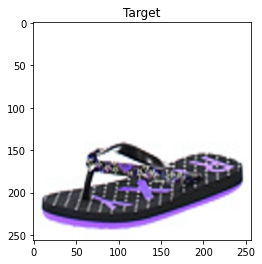

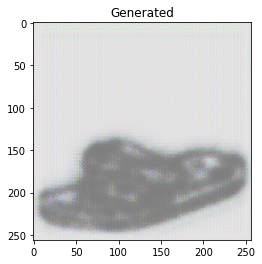

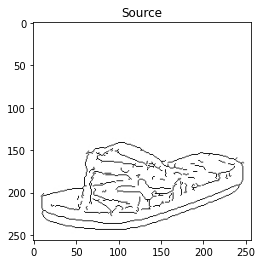

In [14]:
# load the model and make prediction on a given image
cyclegan_model = load_model('cyclegan_generator_AtoB_model.h5')
source_img = cv2.imread(train_files[0])[:, :256]
target_img = cv2.imread(train_files[0])[:, 256:]

# resize
source_img = resize_image(img=source_img, size=IMAGE_SIZE)
target_img = resize_image(img=target_img, size=IMAGE_SIZE)

# scale pixel values
source_img = np.array(source_img)/127.5 - 1.
target_img = np.array(target_img)/127.5 - 1.

# reshape
source_img = np.expand_dims(source_img, 0)
target_img = np.expand_dims(target_img, 0)

# make prediction, re-scale and reshape
gen_img = cyclegan_model.predict(source_img)[0]
gen_img = (gen_img + 1) / 2.0
gen_img = np.expand_dims(gen_img, 0)

# combine and re-scale to (0, 1)
all_imgs = np.concatenate([target_img, gen_img, source_img])
all_imgs = 0.5 * all_imgs + 0.5

titles = ['Target', 'Generated', 'Source']
for idx, i in enumerate(all_imgs):
    plt.imshow(i)
    plt.title(titles[idx])
    plt.show()

# GAN Evaluation using Frechet Inception Distance

In [15]:
class EvalGAN:
    def __init__(self, real_images, fake_images):
        self.real_images = preprocess_input(
            np.array([
                resize_image(i, size=(299, 299)) for i in real_images
            ])
        )
        self.fake_images = preprocess_input(
            np.array([
                resize_image(i, size=(299, 299)) for i in fake_images
            ])
        )
        self.model = InceptionV3(
            include_top=False, 
            pooling='avg', 
            input_shape=(299, 299, 3)
        )
    
    def calculate_fid(self):
        """
        Calculates the Frechet Inception Distance (FID) score.
        Implemented from: https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/
        """
        # calculate activations
        act1 = self.model.predict(self.real_images)
        act2 = self.model.predict(self.fake_images)
        # calculate mean and covariance statistics
        mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
        mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
        # calculate sum squared difference between means
        ssdiff = np.sum((mu1 - mu2)**2.0)
        # calculate sqrt of product between cov
        covmean = sqrtm(sigma1.dot(sigma2))
        # check and correct imaginary numbers from sqrt
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        # calculate score
        fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid


[real_source_images, real_target_images], _ = load_real_samples(
    batch_size=BATCH_SIZE, 
    nbr_patches=1
)

# Evaluate Pix2Pix
fake_target_images, _ = generate_fake_samples(
    generator=p2p_model, 
    real_source_image_samples=real_source_images, 
    nbr_patches=1
)

geval = EvalGAN(real_target_images, fake_target_images)
fid = geval.calculate_fid()
print("Pix2Pix FID:", fid)

# Evaluate CycleGAN
fake_target_images, _ = generate_fake_samples(
    generator=cyclegan_model, 
    real_source_image_samples=real_source_images, 
    nbr_patches=1
)

geval = EvalGAN(real_target_images, fake_target_images)
fid = geval.calculate_fid()
print("CycleGAN FID:", fid)

87916544/87910968 [==============================] - 1s 0us/step
Pix2Pix FID: 69.86341626150781
CycleGAN FID: 59.423587323707665
